# Pryngles module: scatterer

In [1]:
from pryngles import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#@test:template
def test_interface(self):
    
    global MySurface
    Verbose.VERBOSITY=VERB_ALL
    
    class MySurface(Scatterer):
        def __init__(self,**params):
            if self.register(self,params):
                verbose(VERB_SIMPLE,f"Initializing {self.params['name']} with hash {self.hash}")
                #Read parameters of the scatterer
                self.A=params["A"]
                #Initialize scatterer
                self._initialize_scatterer()

        #Mandatory methods
        def get_albedo(self,eta,zeta,delta,lamb,**params):
            albedo=self.AA*eta
            return albedo

        # Private methods to prepare scatterer
        def _initialize_scatterer(self):
            self.AA=self.A**2
        
    Scatterer.reset_catalogue()
    S=MySurface(A=1)
    print(S.hash)
    print(S.get_albedo(0.5,0,0,0))
    S=MySurface(A=1)
    print(S.hash)
    print(S.get_albedo(0.5,0,0,0))
    
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_interface=test_interface
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

  VERB1::register:: Creating a new scatterer with name MySurface and hash 12010540114555749990
  VERB1::__init__:: Initializing MySurface with hash 12010540114555749990
12010540114555749990
0.5
  VERB1::register:: Scatterer with name MySurface and hash 12010540114555749990 already exist at 140557237635008
12010540114555749990
0.5



----------------------------------------------------------------------
Ran 1 test in 0.153s

OK


In [3]:
#@test:template
def test_scatters(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_ALL
    
    print(NeutralSurface().get_albedo(0,0,0,0))
    print(BlackBodySurface().get_albedo(0,0,0,0))

    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_scatters=test_scatters
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

  VERB1::register:: Creating a new scatterer with name NeutralSurface and hash 13240899717716971543
1
  VERB1::register:: Creating a new scatterer with name BlackBodySurface and hash 187880162924494581
0



----------------------------------------------------------------------
Ran 1 test in 0.017s

OK


  VERB1::register:: Scatterer with name LambertianGraySurface and hash 8691060526272545200 already exist at 140557237635008


<IPython.core.display.Javascript object>


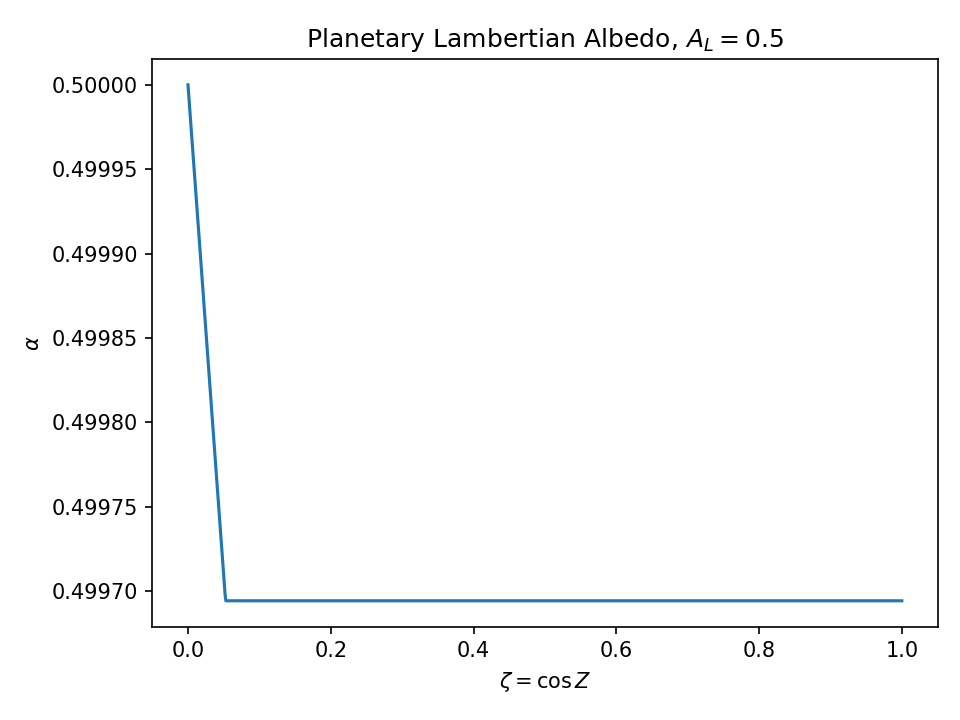

.
----------------------------------------------------------------------
Ran 1 test in 0.050s

OK


In [6]:
#@test:template
def test_lambsurface(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_ALL
    
    LA=LambertianGraySurface(AL=0.5)
    etas=np.linspace(0,1,1000)
    fig,axs=plt.subplots(1,1)

    ax=axs
    ax.plot(etas,LA.get_albedo(etas,0,0,0))
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"$\alpha$")
    ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${LA.AL}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_lambsurface=test_lambsurface
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

  VERB1::register:: Creating a new scatterer with name LambertianGrayAtmosphere and hash 17952562352456873716
  VERB1::__init__:: Initializing LambertianGrayAtmosphere with hash 17952562352456873716


<IPython.core.display.Javascript object>


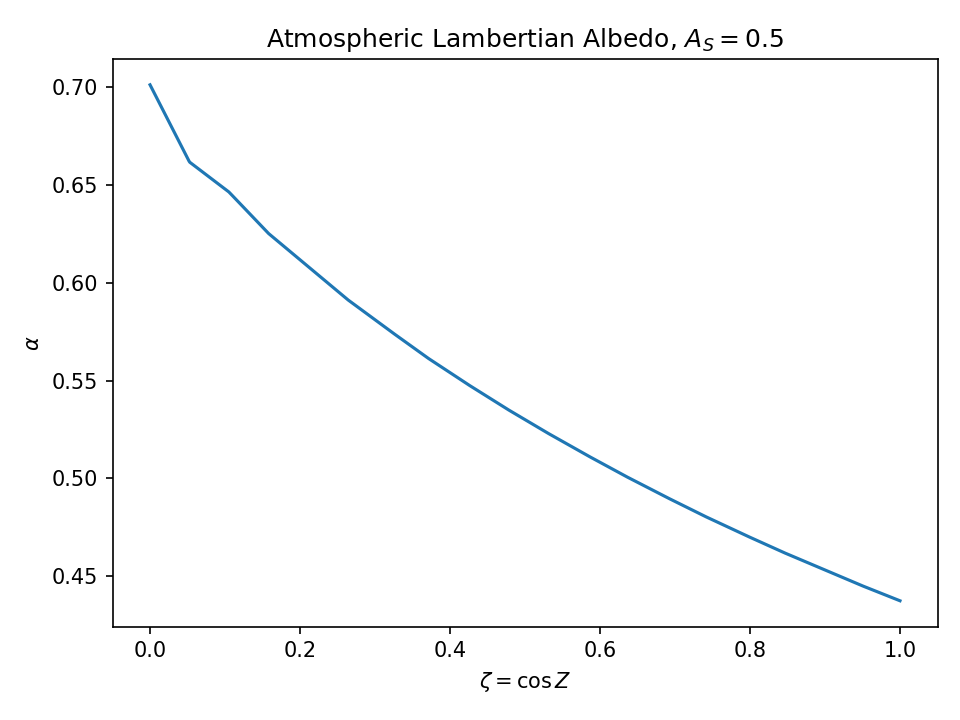

.
----------------------------------------------------------------------
Ran 1 test in 0.318s

OK


In [7]:
#@test:template
def test_lambatmos(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_ALL
    
    LA=LambertianGrayAtmosphere(AS=0.5)
    etas=np.linspace(0,1,1000)
    fig,axs=plt.subplots(1,1)

    ax=axs
    ax.plot(etas,LA.get_albedo(etas,0,0,0))
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"$\alpha$")
    ax.set_title(rf"Atmospheric Lambertian Albedo, $A_S=${LA.AS}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_lambatmos=test_lambatmos
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

In [8]:
#@test:template
def test_catalogue(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_NONE
    
    for key,item in SCATTERERS_CATALOGUE.items():
        print(f"{key}: {item}")

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_catalogue=test_catalogue
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

12010540114555749990: {'params': {'A': 1, 'name': 'MySurface', 'hash': '12010540114555749990'}, 'hash': '12010540114555749990', 'A': 1, 'AA': 1}
13240899717716971543: {'params': {'name': 'NeutralSurface', 'hash': '13240899717716971543'}, 'hash': '13240899717716971543'}
187880162924494581: {'params': {'name': 'BlackBodySurface', 'hash': '187880162924494581'}, 'hash': '187880162924494581'}
8691060526272545200: {'params': {'AL': 0.5, 'name': 'LambertianGraySurface', 'hash': '8691060526272545200'}, 'hash': '8691060526272545200', 'phase_law': <function LambertianGraySurface.__init__.<locals>.<lambda> at 0x7fd5eab290d0>, 'AL': 0.5, 'gammap0': 0.07952880859375}
17952562352456873716: {'params': {'AS': 0.5, 'name': 'LambertianGrayAtmosphere', 'hash': '17952562352456873716'}, 'hash': '17952562352456873716', 'AS': 0.5, 'fint': <scipy.interpolate.interpolate.interp2d object at 0x7fd60916ba30>, 'gamma0': 0.91009521484375}



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [10]:
#@test:template
def test_upscat(self):
    
    global sys
    
    Verbose.VERBOSITY=VERB_NONE
    
    nspangles=50
    sys=System()
    S=sys.add(kind="Star",nspangles=nspangles,
              radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
    P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
              a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=SPANGLE_ATMOSPHERIC)
    R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
              fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)
    
    
    #Prepare system
    sys.initialize_simulation()
    sys.spangle_system()    
    sys.update_scatterers()
    
    #Show scatterers
    for key,item in SCATTERERS_CATALOGUE.items():
        print(f"{key}: {item.params['name']}")
        
    #Show scatterers
    print(sys.data.scatterer.unique())
    print(sys.spangle_scatterers)
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_upscat=test_upscat
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

12010540114555749990: MySurface
13240899717716971543: NeutralSurface
187880162924494581: BlackBodySurface
8691060526272545200: LambertianGraySurface
17952562352456873716: LambertianGrayAtmosphere
17092448437039068465: LambertianGrayAtmosphere
5668689812315627122: LambertianGraySurface
['187880162924494581' '17092448437039068465' '5668689812315627122']
{2: (<class 'pryngles.scatterer.LambertianGrayAtmosphere'>, {'AS': 'albedo_gray_spherical'}), 4: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 3: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 1: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 0: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 5: (<class 'pryngles.scatterer.BlackBodySurface'>, {}), 6: (<class 'pryngles.scatterer.BlackBodySurface'>, {})}



----------------------------------------------------------------------
Ran 1 test in 1.043s

OK


### The end

In [67]:
#@end:module